In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def plot_fit(x,y,mu,var, m_y='k-o', m_mu='b-<', l_y='true', l_mu='predicted', legend=True, title=''):
    """
    Plot the fit of a GP
    """
    if y is not None:
        plt.plot(x,y, m_y, label=l_y)
    plt.plot(x,mu, m_mu, label=l_mu)
    vv = 2*np.sqrt(var)
    plt.fill_between(x[:,0], (mu-vv)[:,0], (mu+vv)[:,0], alpha=0.2, edgecolor='gray', facecolor='cyan')
    if legend:
        plt.legend()
    if title != '':
        plt.title(title)

In [19]:
import datetime as dt
import numpy as np
import pandas as pd
import fxcmpy
from fxcmpy import fxcmpy_tick_data_reader as tdr
import tables as tb
TOKEN = '71ec67818275600cfcb24e9103f517665a313d08'
con = fxcmpy.fxcmpy(access_token=TOKEN, log_level='error')
#con = fxcmpy.fxcmpy(config_file='fxcm.cfg', server='demo')
#print(con.get_instruments())
data = con.get_candles('EUR/USD', period='m5',number=100)
data.head()

#start = dt.datetime(2017, 1, 2)
#end = dt.datetime(2017, 1, 3)
#data = tdr('AUDCAD', start, end, verbosity=True)

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty
date,,,,,,,,,
2019-11-11 09:40:00,1.10326,1.10321,1.10327,1.10305,1.10337,1.10333,1.10337,1.10317,584
2019-11-11 09:45:00,1.10321,1.10304,1.10327,1.10294,1.10333,1.10316,1.10339,1.10306,500
2019-11-11 09:50:00,1.10304,1.10311,1.10316,1.10294,1.10316,1.10324,1.10329,1.10307,468
2019-11-11 09:55:00,1.10311,1.10290,1.10311,1.10278,1.10324,1.10302,1.10324,1.10291,538
2019-11-11 10:00:00,1.10290,1.10289,1.10295,1.10284,1.10302,1.10300,1.10306,1.10296,308


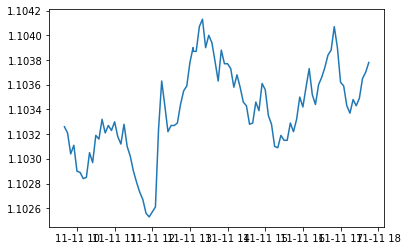

In [20]:
#
plt.plot(data['bidopen'])

In [21]:
ytr=np.array(data['bidopen'])
length=ytr.shape[0]
xtr=np.linspace(1,length,num=length)
ytr=ytr[:,None]
xtr=xtr[:,None]

In [22]:
import GPy
Q = xtr.shape[1]
#k = RationalQuadratic(Q)
k1=GPy.kern.StdPeriodic(Q)
k2=GPy.kern.RBF(Q)
k3=GPy.kern.Linear(Q)
k4=GPy.kern.Poly(Q)

# Combining Polynomial kernal and periodic kernal

Polynomial kernal:
    $$k(x,y)=(x^T*y+c)^d$$


Periodic kernal:
    k(x,y) = $$\theta_1 \exp \left[  - \frac{1}{2} \sum_{i=1}^{input\_dim}
       \left( \frac{\sin(\frac{\pi}{T_i} (x_i - y_i) )}{l_i} \right)^2 \right]$$

Optimization restart 1/50, f = -270.6091025329198
Optimization restart 2/50, f = -515.3650904533637
Optimization restart 3/50, f = -546.9004712862828
Optimization restart 4/50, f = -548.112770909532
Optimization restart 5/50, f = -569.3259193188478
Optimization restart 6/50, f = -360.4705541451258
Optimization restart 7/50, f = -343.3155199827052
Optimization restart 8/50, f = -258.2211997944971
Optimization restart 9/50, f = -512.3968252534343
Optimization restart 10/50, f = -157.85266027090006
Optimization restart 11/50, f = -255.79132359951979
Optimization restart 12/50, f = -439.9392347862595
Optimization restart 13/50, f = -166.61483013645284
Optimization restart 14/50, f = -612.5623523061269
Optimization restart 15/50, f = -514.8470142773915
Optimization restart 16/50, f = -374.8205241047581
Optimization restart 17/50, f = -453.154962370178
Optimization restart 18/50, f = -681.4510520873257
Optimization restart 19/50, f = -279.36594508192627
Optimization restart 20/50, f = -659.5

GP_regression.,value,constraints,priors
sum.std_periodic.variance,8.714865869915461e-08,+ve,
sum.std_periodic.period,170.16586067442205,+ve,
sum.std_periodic.lengthscale,0.0577131096676438,+ve,
sum.poly.variance,0.017289488462446188,+ve,
sum.poly.scale,3.761831971105958e-11,+ve,
sum.poly.bias,4.1286855516463685,+ve,
Gaussian_noise.variance,1.2448728354118445e-23,+ve,


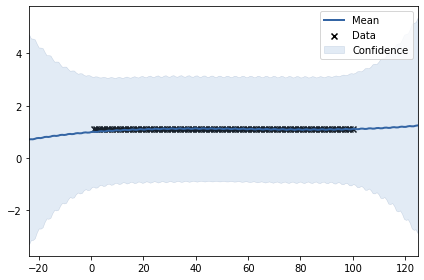

In [87]:
k=k1+k4 #polynomial kernal and periodic kernal
m = GPy.models.GPRegression(X=xtr, Y=ytr, kernel=k)
m.plot() #before optimization
m.optimize(messages=False)
m.optimize_restarts(num_restarts = 50, messages=False)
display(m)

{'dataplot': [<matplotlib.collections.PathCollection at 0x2cc8f9c6248>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2cc91da1ec8>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2cc91de1848>]}

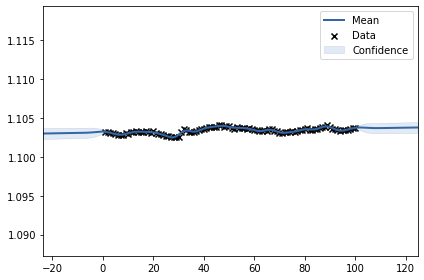

In [88]:
m.plot()


Name : GP regression
Objective : -731.4893438039622
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.                |                   value  |  constraints  |  priors
  sum.std_periodic.variance     |   8.714865869915461e-08  |      +ve      |        
  sum.std_periodic.period       |      170.16586067442205  |      +ve      |        
  sum.std_periodic.lengthscale  |      0.0577131096676438  |      +ve      |        
  sum.poly.variance             |    0.017289488462446188  |      +ve      |        
  sum.poly.scale                |   3.761831971105958e-11  |      +ve      |        
  sum.poly.bias                 |      4.1286855516463685  |      +ve      |        
  Gaussian_noise.variance       |  1.2448728354118445e-23  |      +ve      |        


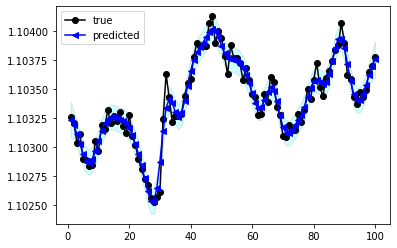

In [89]:
print(m)
X_star=xtr
Y_star=ytr
mu,var = m.predict(X_star)
plot_fit(X_star, Y_star, mu, var)

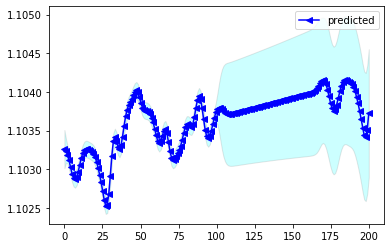

In [90]:
X_extrap=np.linspace(0,200,200)[:,None]
mu,var = m.predict(X_extrap)
plot_fit(X_extrap, None, mu, var)


# RBF Kernal


$$k(r) = \sigma^2 \exp \bigg(- \frac{1}{2} r^2 \bigg)$$

Optimization restart 1/50, f = -665.7879357639973
Optimization restart 2/50, f = 151.7331187011327
Optimization restart 3/50, f = -648.4100570470582
Optimization restart 4/50, f = -665.5965225205344
Optimization restart 5/50, f = -648.410056712998
Optimization restart 6/50, f = -665.5965230238425
Optimization restart 7/50, f = -648.410056419857
Optimization restart 8/50, f = -665.5965227947773
Optimization restart 9/50, f = -665.5965227721672
Optimization restart 10/50, f = -648.4101981825031
Optimization restart 11/50, f = -648.410055965928
Optimization restart 12/50, f = -663.9300749171973
Optimization restart 13/50, f = 151.733119344302
Optimization restart 14/50, f = -648.4100555955673
Optimization restart 15/50, f = -648.4100562017107
Optimization restart 16/50, f = 151.73311934430285
Optimization restart 17/50, f = -648.4102393659564
Optimization restart 18/50, f = -648.4100583777284
Optimization restart 19/50, f = -648.4100568341335
Optimization restart 20/50, f = -648.410055955

 C:\Users\cheng\Anaconda3\lib\site-packages\GPy\kern\src\rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 25/50, f = -644.7556797339058
Optimization restart 26/50, f = -665.5965227242136
Optimization restart 27/50, f = -665.5965227653348
Optimization restart 28/50, f = -648.4103937284277
Optimization restart 29/50, f = -665.5965225861387
Optimization restart 30/50, f = -665.7879358584809
Optimization restart 31/50, f = -665.5965227549125
Optimization restart 32/50, f = -648.410055718554
Optimization restart 33/50, f = -665.5965224085485
Optimization restart 34/50, f = -665.5965230026159
Optimization restart 35/50, f = -665.5965224425324
Optimization restart 36/50, f = -665.5965232173935
Optimization restart 37/50, f = 151.73311934430203
Optimization restart 38/50, f = -648.4100557978428
Optimization restart 39/50, f = -665.7879355952604
Optimization restart 40/50, f = -648.4100554377808
Optimization restart 41/50, f = -665.5965225591965
Optimization restart 42/50, f = -665.5965229902723
Optimization restart 43/50, f = -665.7879355624825
Optimization restart 44/50, f = 

GP_regression.,value,constraints,priors
rbf.variance,0.9874007997480281,+ve,
rbf.lengthscale,41.53629157618186,+ve,
Gaussian_noise.variance,1.8326157326104093e-08,+ve,


{'dataplot': [<matplotlib.collections.PathCollection at 0x2cc8d6f4e08>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2cc8d73abc8>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2cc8d6e8108>]}

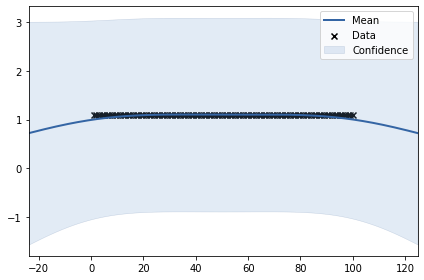

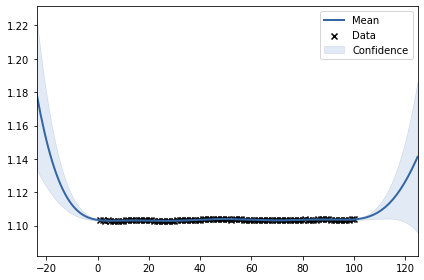

In [91]:
k=k2
m = GPy.models.GPRegression(X=xtr, Y=ytr, kernel=k)
m.plot() #before optimization
m.optimize(messages=False)
m.optimize_restarts(num_restarts = 50, messages=False)
display(m)
m.plot() #after optimization


Name : GP regression
Objective : -665.7879358584809
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |      0.9874007997480281  |      +ve      |        
  rbf.lengthscale          |       41.53629157618186  |      +ve      |        
  Gaussian_noise.variance  |  1.8326157326104093e-08  |      +ve      |        


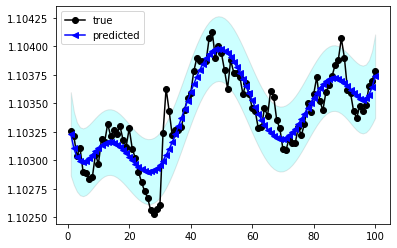

In [92]:
print(m)
X_star=xtr
Y_star=ytr
mu,var = m.predict(X_star)
plot_fit(X_star, Y_star, mu, var)

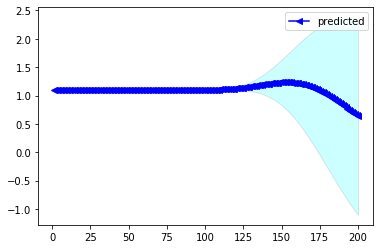

In [93]:
X_extrap=np.linspace(1,200,200)[:,None]
mu,var = m.predict(X_extrap)
plot_fit(X_extrap, None, mu, var)

# Combine RBF kernal and Polynomial kernal

 C:\Users\cheng\Anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/20, f = -731.608324062955
Optimization restart 2/20, f = -665.0763933716667
Optimization restart 3/20, f = -717.5591411503195
Optimization restart 4/20, f = -440.23085740189913
Optimization restart 5/20, f = -712.4370074637579
Optimization restart 6/20, f = -686.1242883393686
Optimization restart 7/20, f = -663.5364472568053
Optimization restart 8/20, f = -161.65352457869164
Optimization restart 9/20, f = -731.283011047133
Optimization restart 10/20, f = -698.8793701052568
Optimization restart 11/20, f = -619.9406623443542
Optimization restart 12/20, f = -273.25910753909704
Optimization restart 13/20, f = -731.6117787862621
Optimization restart 14/20, f = -194.2322190024396
Optimization restart 15/20, f = -691.2781656444342
Optimization restart 16/20, f = -730.8482258820411
Optimization restart 17/20, f = -730.3886308552651
Optimization restart 18/20, f = -730.3536324892174
Optimization restart 19/20, f = -730.6538029195643
Optimization restart 20/20, f = -692.43

GP_regression.,value,constraints,priors
sum.rbf.variance,8.033377467909804e-08,+ve,
sum.rbf.lengthscale,3.0660342401087437,+ve,
sum.std_periodic.variance,1.217918336165025,+ve,
sum.std_periodic.period,53.88468889346085,+ve,
sum.std_periodic.lengthscale,2829.585619071455,+ve,
Gaussian_noise.variance,5.562684646268137e-309,+ve,


{'dataplot': [<matplotlib.collections.PathCollection at 0x2cc8aa06ec8>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2cc8aa06388>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2cc8bba9a08>]}

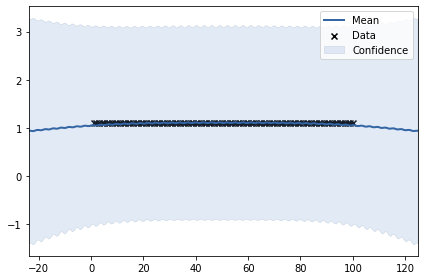

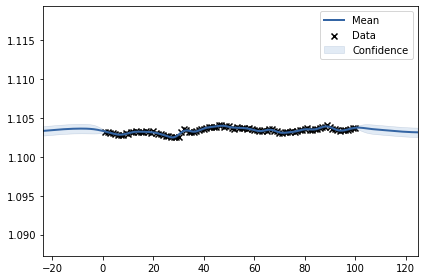

In [94]:
k=k2+k1
m = GPy.models.GPRegression(X=xtr, Y=ytr, kernel=k)
m.plot() #before optimization
m.optimize(messages=False)
m.optimize_restarts(num_restarts = 20, messages=False)
display(m)
m.plot() #after optimization


Name : GP regression
Objective : -731.6117787862621
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.                |                   value  |  constraints  |  priors
  sum.rbf.variance              |   8.033377467909804e-08  |      +ve      |        
  sum.rbf.lengthscale           |      3.0660342401087437  |      +ve      |        
  sum.std_periodic.variance     |       1.217918336165025  |      +ve      |        
  sum.std_periodic.period       |       53.88468889346085  |      +ve      |        
  sum.std_periodic.lengthscale  |       2829.585619071455  |      +ve      |        
  Gaussian_noise.variance       |  5.562684646268137e-309  |      +ve      |        


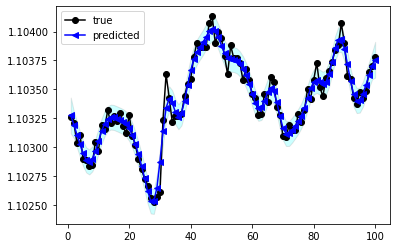

In [95]:
print(m)
X_star=xtr
Y_star=ytr
mu,var = m.predict(X_star)
plot_fit(X_star, Y_star, mu, var)

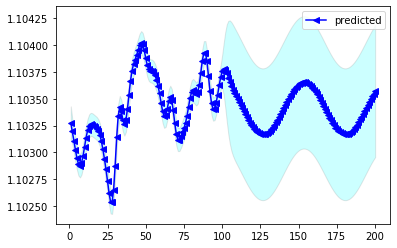

In [96]:
X_extrap=np.linspace(1,200,200)[:,None]
mu,var = m.predict(X_extrap)
plot_fit(X_extrap, None, mu, var)

# Combine linear kernal and periodic kernal

The linear kernal is defined as:
$$k(x,y) = \sum_{i=1}^{\text{input_dim}} \sigma^2_i x_iy_i$$

Optimization restart 1/20, f = -653.9893293500718
Optimization restart 2/20, f = -652.6455711447691
Optimization restart 3/20, f = -672.327240374351
Optimization restart 4/20, f = -689.1284279019812
Optimization restart 5/20, f = -635.444268014824
Optimization restart 6/20, f = -652.6455387678951
Optimization restart 7/20, f = -647.862627171679
Optimization restart 8/20, f = -623.8769326068011
Optimization restart 9/20, f = -340.8823414892107
Optimization restart 10/20, f = -634.5810293335138
Optimization restart 11/20, f = -652.6455285399788
Optimization restart 12/20, f = -652.6456112154617
Optimization restart 13/20, f = -631.605817713351
Optimization restart 14/20, f = -651.2289305902236
Optimization restart 15/20, f = -307.4555129273083
Optimization restart 16/20, f = -652.6456052786089
Optimization restart 17/20, f = -439.6239884063178
Optimization restart 18/20, f = -364.893272448173
Optimization restart 19/20, f = -652.6453514117359
Optimization restart 20/20, f = -332.90315655

GP_regression.,value,constraints,priors
sum.linear.variances,5.081117314483699e-11,+ve,
sum.std_periodic.variance,0.605757355806409,+ve,
sum.std_periodic.period,77.14087716495976,+ve,
sum.std_periodic.lengthscale,23.655634636108147,+ve,
Gaussian_noise.variance,2.3412725911416773e-08,+ve,


{'dataplot': [<matplotlib.collections.PathCollection at 0x2cc836e7a48>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x2cc864d1488>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x2ccfb7320c8>]}

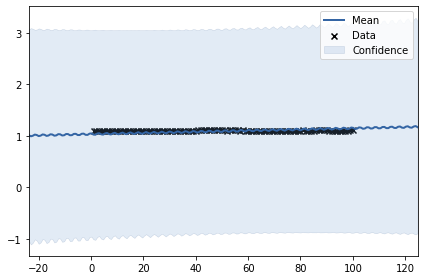

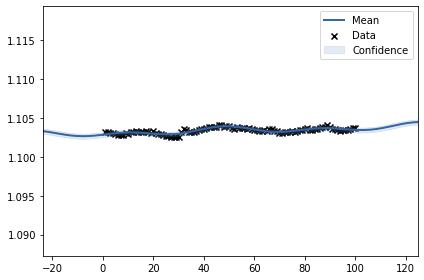

In [97]:
k=k3+k1
m = GPy.models.GPRegression(X=xtr, Y=ytr, kernel=k)
m.plot() #before optimization
m.optimize(messages=False)
m.optimize_restarts(num_restarts = 20, messages=False)
display(m)
m.plot() #after optimization


Name : GP regression
Objective : -689.1284279019812
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.                |                   value  |  constraints  |  priors
  sum.linear.variances          |   5.081117314483699e-11  |      +ve      |        
  sum.std_periodic.variance     |       0.605757355806409  |      +ve      |        
  sum.std_periodic.period       |       77.14087716495976  |      +ve      |        
  sum.std_periodic.lengthscale  |      23.655634636108147  |      +ve      |        
  Gaussian_noise.variance       |  2.3412725911416773e-08  |      +ve      |        


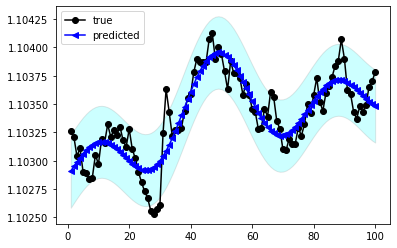

In [98]:
print(m)
X_star=xtr
Y_star=ytr
mu,var = m.predict(X_star)
plot_fit(X_star, Y_star, mu, var)

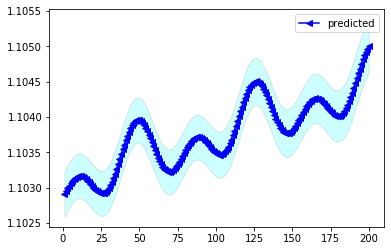

In [99]:
X_extrap=np.linspace(1,200,200)[:,None]
mu,var = m.predict(X_extrap)
plot_fit(X_extrap, None, mu, var)